## About

In this notebook we prepare a simple solution.

In [1]:
import pandas
import numpy
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss

### Download data

* Create the folder `datasets`
* Download files from kaggle to this folder

### Read training and test files

In [2]:
data = pandas.read_csv('datasets/training.csv.gz')
test = pandas.read_csv('datasets/test.csv.gz')

In [3]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,...,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,...,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,...,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,...,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,...,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,...,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


### Look at the labels set

In [4]:
set(data.Label)

{'Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'}

### Define training features

Exclude `Label` from the features set

In [5]:
features = list(set(data.columns) - {'Label'})

### Divide training data into 2 parts

In [6]:
training_data, other_data = train_test_split(data, random_state=11, train_size=0.3)
validation_data, final_validation_data = train_test_split(other_data, random_state=11, train_size=0.5)

In [7]:
len(training_data), len(validation_data), len(final_validation_data)

(360000, 420000, 420000)

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(training_data.Label)
le.classes_

array(['Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'], dtype=object)

In [9]:
# Import all data to xgboost DMatrix 
import xgboost as xgb
dtrain = xgb.DMatrix(training_data[features], label=le.transform(training_data.Label), missing=-999.0) 
dvalid = xgb.DMatrix(validation_data[features], missing=-999.0)
dfinal_valid = xgb.DMatrix(final_validation_data[features], missing=-999.0)

def get_train_loss(model):
    proba = model.predict(dtrain)
    return log_loss(training_data.Label, proba)

def get_valid_loss(model):
    proba = model.predict(dvalid)
    return log_loss(validation_data.Label, proba)

def get_final_valid_loss(model):
    proba = model.predict(dfinal_valid)
    return log_loss(final_validation_data.Label, proba)

Let's estimate optimal hiperparemeters for learning_rate = 0.2

In [10]:
base_params = {
    'eta': 0.2,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': 6,
    'subsample': 0.4, 
    'seed': 0,
    "max_depth": 7
}

In [11]:
def train_and_validate(params, iterations = 100):
    cp = base_params.copy()
    cp.update(params)
    bst = xgb.train(cp, dtrain, iterations)
    return (get_train_loss(bst), get_valid_loss(bst))

In [12]:
%%time
train_and_validate({})

CPU times: user 55min 13s, sys: 5.23 s, total: 55min 18s
Wall time: 8min 14s


(0.4878922394904634, 0.56832896061169591)

In [13]:
import itertools

def grid_search(**params_grid):
    "Simple, but fast grid_search"
    result = []
    params, values = zip(*params_grid.iteritems())
    for val in itertools.product(*values):
        params = dict(zip(params, val))
        train, valid = train_and_validate(params)
        
        txt = "train: {:0.6f}, valid: {:0.6f}, params: {}".format(train, valid, params)
        print(txt)
        result.append(txt)
    
    return result

Попробуем подобрать оптимальные гиперпараметры. 

In [14]:
log = grid_search(
 max_depth = [8, 9, 10],
 min_child_weight=[4, 5, 6])

train: 0.465019, valid: 0.566944, params: {'max_depth': 8, 'min_child_weight': 4}
train: 0.468429, valid: 0.566790, params: {'max_depth': 8, 'min_child_weight': 5}
train: 0.470781, valid: 0.566370, params: {'max_depth': 8, 'min_child_weight': 6}
train: 0.429503, valid: 0.567485, params: {'max_depth': 9, 'min_child_weight': 4}
train: 0.434350, valid: 0.568084, params: {'max_depth': 9, 'min_child_weight': 5}
train: 0.439639, valid: 0.567374, params: {'max_depth': 9, 'min_child_weight': 6}
train: 0.389535, valid: 0.570973, params: {'max_depth': 10, 'min_child_weight': 4}
train: 0.398661, valid: 0.570984, params: {'max_depth': 10, 'min_child_weight': 5}
train: 0.405888, valid: 0.569886, params: {'max_depth': 10, 'min_child_weight': 6}


In [15]:
base_params["max_depth"] = 9
base_params["min_child_weight"] = 5

log = grid_search(
    gamma = [i/10.0 for i in range(0,6)])

train: 0.434350, valid: 0.568084, params: {'gamma': 0.0}
train: 0.433174, valid: 0.567806, params: {'gamma': 0.1}
train: 0.434530, valid: 0.566991, params: {'gamma': 0.2}
train: 0.433085, valid: 0.567657, params: {'gamma': 0.3}
train: 0.434616, valid: 0.567820, params: {'gamma': 0.4}
train: 0.436103, valid: 0.567451, params: {'gamma': 0.5}


In [16]:
base_params.update({
    "max_depth": 9,
    "min_child_weight": 5,
    "gamma": 0})

log = grid_search(
 subsample = [0.8, 0.9, 1.0],
 colsample_bytree=[0.8, 0.9, 1.0])

train: 0.415432, valid: 0.558475, params: {'subsample': 0.8, 'colsample_bytree': 0.8}
train: 0.413474, valid: 0.557838, params: {'subsample': 0.8, 'colsample_bytree': 0.9}
train: 0.411045, valid: 0.557932, params: {'subsample': 0.8, 'colsample_bytree': 1.0}
train: 0.411836, valid: 0.557977, params: {'subsample': 0.9, 'colsample_bytree': 0.8}
train: 0.413065, valid: 0.557660, params: {'subsample': 0.9, 'colsample_bytree': 0.9}
train: 0.410517, valid: 0.557948, params: {'subsample': 0.9, 'colsample_bytree': 1.0}
train: 0.416000, valid: 0.558274, params: {'subsample': 1.0, 'colsample_bytree': 0.8}
train: 0.415769, valid: 0.557709, params: {'subsample': 1.0, 'colsample_bytree': 0.9}
train: 0.412943, valid: 0.557566, params: {'subsample': 1.0, 'colsample_bytree': 1.0}


In [19]:
base_params.update({
    "max_depth": 9,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 1.0,
    "colsample_bytree": 1.0
})

log = grid_search(
 alpha = [0.1, 1, 10])

train: 0.414585, valid: 0.558460, params: {'alpha': 0.1}
train: 0.413840, valid: 0.557313, params: {'alpha': 1}
train: 0.456577, valid: 0.556500, params: {'alpha': 10}


In [20]:
base_params.update({
    "max_depth": 9,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "alpha": 0.1
})

log = grid_search(
 colsample_bylevel=[0.8, 0.9, 1.0],
 colsample_bytree=[0.8, 0.9, 1.0])

train: 0.418288, valid: 0.557234, params: {'colsample_bytree': 0.8, 'colsample_bylevel': 0.8}
train: 0.416366, valid: 0.557686, params: {'colsample_bytree': 0.8, 'colsample_bylevel': 0.9}
train: 0.414448, valid: 0.557863, params: {'colsample_bytree': 0.8, 'colsample_bylevel': 1.0}
train: 0.414988, valid: 0.557509, params: {'colsample_bytree': 0.9, 'colsample_bylevel': 0.8}
train: 0.415081, valid: 0.557603, params: {'colsample_bytree': 0.9, 'colsample_bylevel': 0.9}
train: 0.414439, valid: 0.557474, params: {'colsample_bytree': 0.9, 'colsample_bylevel': 1.0}
train: 0.415760, valid: 0.558192, params: {'colsample_bytree': 1.0, 'colsample_bylevel': 0.8}
train: 0.414088, valid: 0.557984, params: {'colsample_bytree': 1.0, 'colsample_bylevel': 0.9}
train: 0.414585, valid: 0.558460, params: {'colsample_bytree': 1.0, 'colsample_bylevel': 1.0}


In [21]:
final_params = base_params.copy()
final_params.update({
        'colsample_bylevel': 0.9,
        'colsample_bytree': 0.9
    })

bst = xgb.train(final_params, dtrain, 100)
get_final_valid_loss(bst)

0.55659471596916943

In [22]:
final_params = base_params.copy()
final_params.update({
    "max_depth": 10,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 0.9,
    'colsample_bylevel': 0.9,
    'colsample_bytree': 0.9,
    "alpha": 0.1
})

bst = xgb.train(final_params, dtrain, 100)
get_final_valid_loss(bst)

0.55615236467033202

### Now let's put more sample to train set and decrease learning rate

In [23]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.95)

dtrain = xgb.DMatrix(training_data[features], label=le.transform(training_data.Label), missing=-999.0) 
dvalid = xgb.DMatrix(validation_data[features], missing=-999.0)

# Параметры не оптимальные, но они были ипользованы для решения. Лучше подобрать времени не хватило.
final_params = base_params.copy()
final_params.update({
    "eta": 0.02,
    "max_depth": 10,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 0.9,
    'colsample_bylevel': 0.9,
    'colsample_bytree': 0.9,
    "alpha": 0.1
})
bst = xgb.Booster(final_params, [dtrain, dvalid])
iteration_number = 0

In [25]:
# Эту ячейку нужно запускать несколько раз для конченого результата
for i in range(500):
    bst.update(dtrain, iteration_number)
    proba = bst.predict(dvalid)
    loss = log_loss(validation_data.Label, proba)
    print("i: {}, validation: {}".format(iteration_number + 1, loss))
    iteration_number += 1

proba = bst.predict(dtrain)
loss = log_loss(training_data.Label, proba)
print("done. train loss: {}".format(loss))

i: 501, validation: 0.553256211304
i: 502, validation: 0.553171130165
i: 503, validation: 0.553081939665
i: 504, validation: 0.553020609549
i: 505, validation: 0.552960602535
i: 506, validation: 0.552890627389
i: 507, validation: 0.552797466812
i: 508, validation: 0.55270152125
i: 509, validation: 0.552616406046
i: 510, validation: 0.552540656463
i: 511, validation: 0.552462649939
i: 512, validation: 0.552385043498
i: 513, validation: 0.552303121394
i: 514, validation: 0.552223832395
i: 515, validation: 0.552133199701
i: 516, validation: 0.552069757329
i: 517, validation: 0.551982669447
i: 518, validation: 0.55192349486
i: 519, validation: 0.551855909711
i: 520, validation: 0.55177667523
i: 521, validation: 0.551704369608
i: 522, validation: 0.551640086668
i: 523, validation: 0.551567099195
i: 524, validation: 0.551477135126
i: 525, validation: 0.551419115917
i: 526, validation: 0.551341206361
i: 527, validation: 0.551269497076
i: 528, validation: 0.551197814532
i: 529, validation: 0.5

## Prepare submission to kaggle

In [26]:
# predict test sample
kaggle_proba = bst.predict(xgb.DMatrix(test[features], missing=-999.0))
kaggle_ids = test.ID

In [27]:
from IPython.display import FileLink
def create_solution(ids, proba, names, filename='baseline_2.csv'):
    """saves predictions to file and provides a link for downloading """
    solution = pandas.DataFrame({'ID': ids})
    for name in ['Ghost', 'Electron', 'Muon', 'Pion', 'Kaon', 'Proton']:
        solution[name] = proba[:, numpy.where(names == name)[0]]
    solution.to_csv('datasets/{}'.format(filename), index=False, float_format='%.5f')
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba, le.classes_)

/home/atsky/work/LHC/datasets/baseline_2.csv

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
lb = preprocessing.LabelBinarizer()
lb.fit(validation_data.Label)
proba = bst.predict(dvalid)
loss_array = -numpy.log(numpy.sum(proba * lb.transform(validation_data.Label), axis=1))

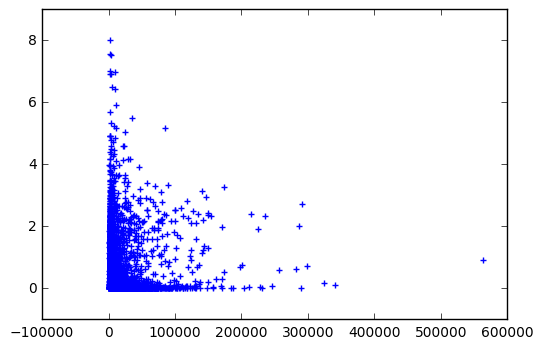

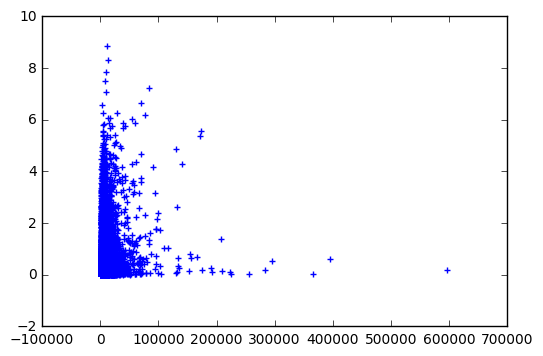

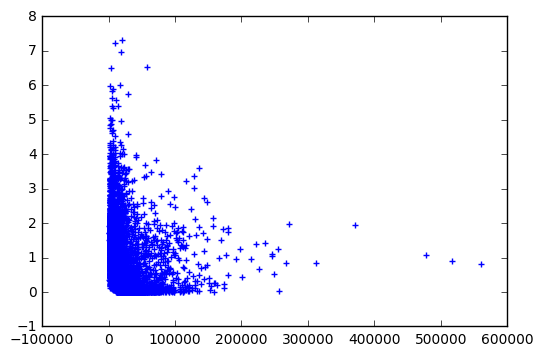

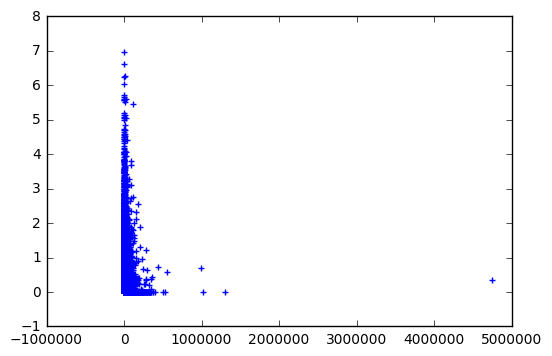

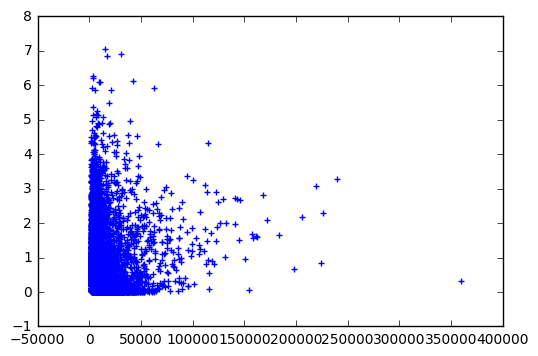

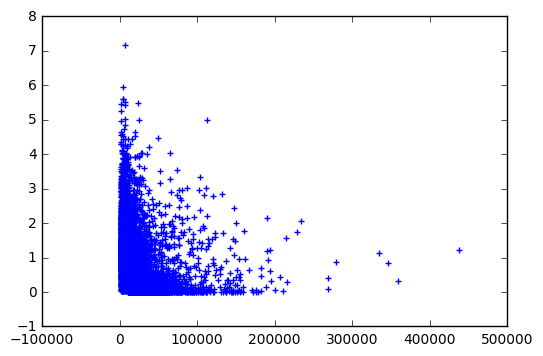

In [32]:
import matplotlib.pyplot as plt
for part in ['Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton']:
    x = validation_data.TrackP[validation_data.Label == part]
    y = loss_array[(validation_data.Label == part).values]

    plt.scatter(x, y, marker='+')
    plt.show()

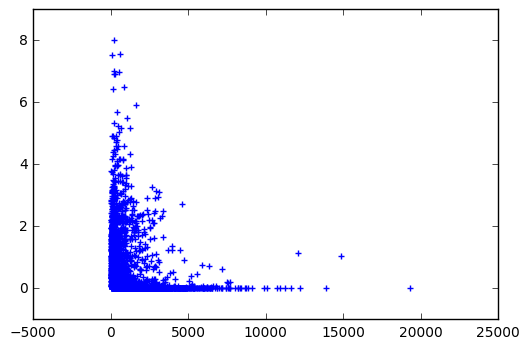

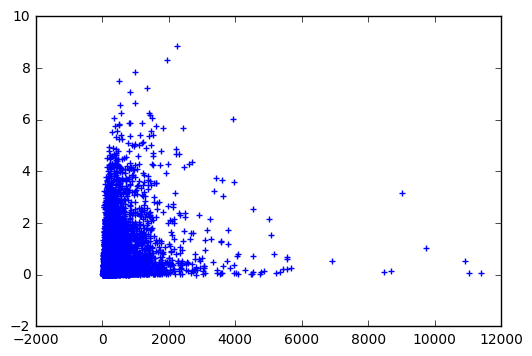

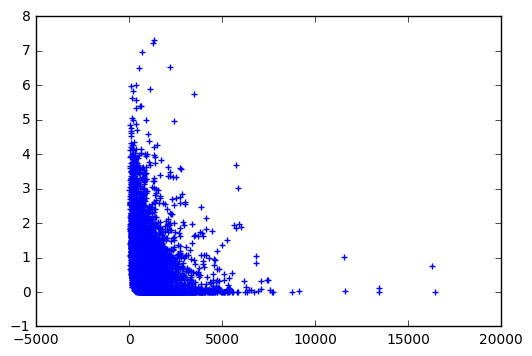

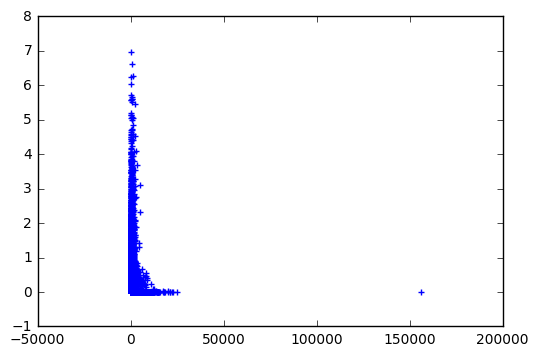

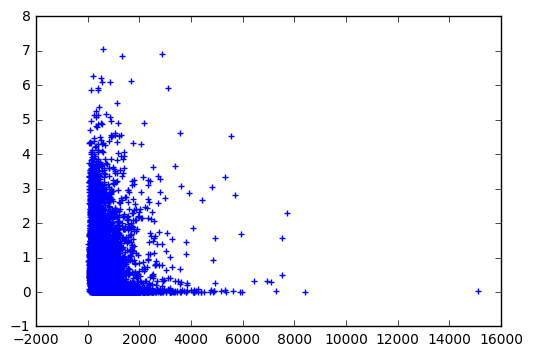

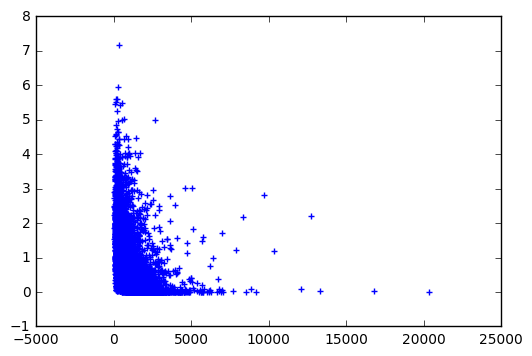

In [33]:
import matplotlib.pyplot as plt
for part in ['Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton']:
    x = validation_data.TrackPt[validation_data.Label == part]
    y = loss_array[(validation_data.Label == part).values]

    plt.scatter(x, y, marker='+')
    plt.show()